In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import librosa
import librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
import keras

import logging, os

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

# File Name Preparation

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database")

In [ ]:
file_list = os.listdir('/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database')
wav_list = sorted([wav for wav in file_list if ".wav" in wav])
txt_list = sorted([txt for txt in file_list if ".txt" in txt])
print("Total audio file :{}\nTotal txt file: {}".format(len(wav_list), len(txt_list)))

Total audio file :547
Total txt file: 547


## Text File

In [ ]:
df_txt = pd.DataFrame()
for txt_file in txt_list :
  temp = pd.read_csv(txt_file,sep='\t',names=['start','end','crackles','weezels'])
  temp["file_name"] = txt_file.split(".")[0]
  df_txt = pd.concat((df_txt, temp))

In [ ]:
df_txt.head(3)

,start,end,crackles,weezels,file_name
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron


In [ ]:
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4199 entries, 0 to 4
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   start      4199 non-null   float64
 1   end        4199 non-null   float64
 2   crackles   4199 non-null   int64  
 3   weezels    4199 non-null   int64  
 4   file_name  4199 non-null   object 
dtypes: float64(2), int64(2), object(1)
memory usage: 196.8+ KB


# Patient Diagnosis

In [ ]:
'''
Patient Diagnosis
'''
diag = pd.read_csv("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/patient_diagnosis.csv", header = None).rename(columns = {0 : "patient", 1 : "diag_0"})
diag["diag_1"] = diag["diag_0"].replace({'Pneumonia': "LRTI", 'Bronchiolitis' : "LRTI"}) #'Bronchiectasis' : "LRTI"
diag["patient"] = diag["patient"].astype(int)
diag = diag.set_index("patient")
diag.head()

,diag_0,diag_1
patient,,
101,URTI,URTI
102,Healthy,Healthy
103,Asthma,Asthma
104,COPD,COPD
105,URTI,URTI


In [ ]:
type(diag.index[0])

numpy.int64

In [ ]:
diag["diag_0"].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: diag_0, dtype: int64

In [ ]:
diag["diag_1"].value_counts()

COPD              64
Healthy           26
URTI              14
LRTI              14
Bronchiectasis     7
Asthma             1
Name: diag_1, dtype: int64

# DataFrame

In [ ]:
'''
Create DataFrame for all files
'''
'''
Extract Information
'''
df = pd.DataFrame()
files_information = df_txt["file_name"].str.split("_")
df["patient_id"] = files_information.apply(lambda row : int(row[0]))
df["rec_index"] = files_information.apply(lambda row : row[1])
df["chest_loc"] = files_information.apply(lambda row : row[2])
df["acq_mode"] = files_information.apply(lambda row : row[3])
df["rec_equip"] = files_information.apply(lambda row : row[4])
df = pd.concat((df, df_txt), axis = 1)

'''
Apply Patient diagnosis
'''
df["diag"] = df["patient_id"].map(diag["diag_1"].to_dict())

df.head()

,patient_id,rec_index,chest_loc,acq_mode,rec_equip,start,end,crackles,weezels,file_name,diag
0,101,1b1,Al,sc,Meditron,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,URTI
1,101,1b1,Al,sc,Meditron,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,URTI
2,101,1b1,Al,sc,Meditron,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,URTI
3,101,1b1,Al,sc,Meditron,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,URTI
4,101,1b1,Al,sc,Meditron,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,URTI


In [ ]:
df["diag"].value_counts() / len(df) * 100

COPD              83.019767
LRTI               8.263872
Healthy            4.191474
URTI               3.286497
Bronchiectasis     1.095499
Asthma             0.142891
Name: diag, dtype: float64

# Data Preparation for Modeling

In [ ]:
audio_arr = np.load("audio_file.npy")

In [ ]:
def getFeatures(row, sample_rate = 22050):
    #soundArr,sample_rate=lb.load(path)
    mfcc=librosa.feature.mfcc(y=row,sr=sample_rate) #mfcc
    cstft=librosa.feature.chroma_stft(y=row,sr=sample_rate) #chroma short-term Fourier transformation
    mSpec=librosa.feature.melspectrogram(y=row,sr=sample_rate) #melspectogram

    return mfcc,cstft,mSpec

mfcc_arr,cstft_arr,mSpec_arr=[],[],[]

for arr in audio_arr:
    a,b,c = getFeatures(arr)
    mfcc_arr.append(a)
    cstft_arr.append(b)
    mSpec_arr.append(c)

mfcc_arr = np.array(mfcc_arr)
cstft_arr = np.array(cstft_arr)
mSpec_arr = np.array(mSpec_arr)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
del audio_arr

In [ ]:
len(mfcc_arr)

6898

In [ ]:
df["mfcc"] = pd.Series(list(mfcc_arr))
df["cstft"] = pd.Series(list(cstft_arr))
df["mspec"] = pd.Series(list(mSpec_arr))
df["len_mfcc"] = df["mfcc"].apply(lambda row : len(row))
df["len_cstft"] = df["cstft"].apply(lambda row : len(row))
df["len_mspec"] = df["mspec"].apply(lambda row : len(row))
df.head()

,patient_id,rec_index,chest_loc,acq_mode,rec_equip,start,end,crackles,weezels,file_name,diag,mfcc,cstft,mspec,len_mfcc,len_cstft,len_mspec
0,101,1b1,Al,sc,Meditron,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,URTI,"[[-613.4402, -613.4402, -613.4402, -613.4402, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",20,12,128
1,101,1b1,Al,sc,Meditron,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,URTI,"[[-621.05994, -621.05994, -621.05994, -621.059...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",20,12,128
2,101,1b1,Al,sc,Meditron,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,URTI,"[[-619.62665, -619.62665, -619.62665, -619.626...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",20,12,128
3,101,1b1,Al,sc,Meditron,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,URTI,"[[-629.2678, -629.2678, -629.2678, -629.2678, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",20,12,128
4,101,1b1,Al,sc,Meditron,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,URTI,"[[-655.7785, -655.7785, -655.7785, -655.7785, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",20,12,128


# Display Wave Sound

## From MFCC

(20, 259)


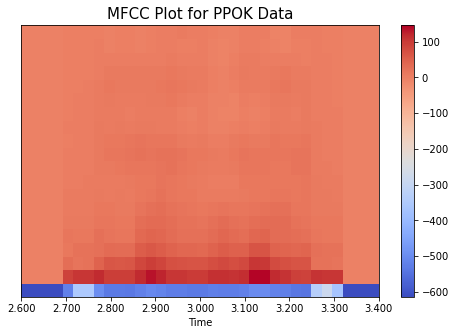

In [ ]:
mfccs = df.iloc[42]["mfcc"]
print(mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (8,5))
img = librosa.display.specshow(mfccs, sr = 22050, x_axis='time')
plt.colorbar(img)
plt.title("MFCC Plot for PPOK Data", fontsize = 15)
plt.xlim(2.6,3.4)
plt.show()

(20, 259)


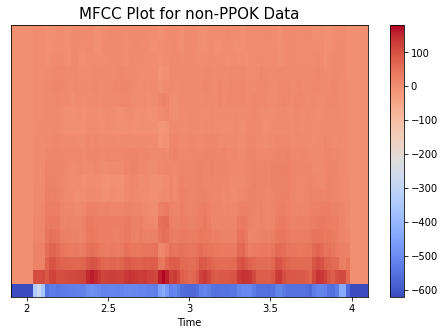

In [ ]:
mfccs = df.iloc[24]["mfcc"]
print(mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (8,5))
img = librosa.display.specshow(mfccs, sr = 22050, x_axis='time')
plt.colorbar(img)
plt.title("MFCC Plot for non-PPOK Data", fontsize = 15)
plt.xlim(1.9,4.1)
plt.show()

In [ ]:
'''
Matrix Similarity
'''
a = df.iloc[42]["mfcc"].flatten()
b = df.iloc[100]["mfcc"].flatten()

from scipy import spatial
result = 1 - spatial.distance.cosine(a, b)
result

0.9856603741645813

## From CSTFT

(12, 259)


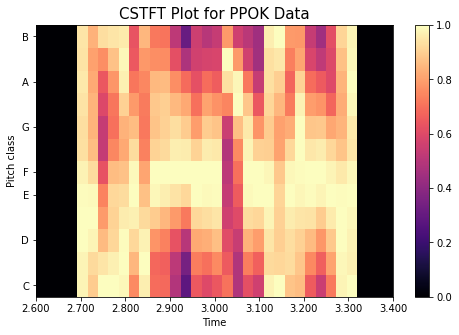

In [ ]:
chroma = df.iloc[42]["cstft"]
print(chroma.shape)

#Displaying  the Chroma:
plt.figure(figsize = (8,5))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar(img)
plt.title("CSTFT Plot for PPOK Data", fontsize = 15)
plt.xlim(2.6,3.4)
plt.show()

(12, 259)


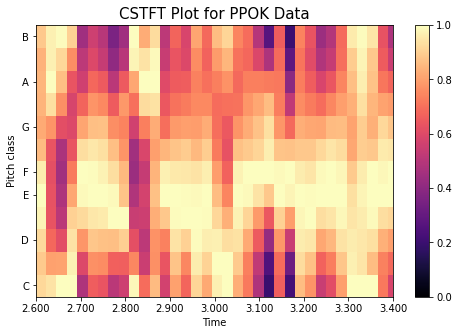

In [ ]:
chroma = df.iloc[24]["cstft"]
print(chroma.shape)

#Displaying  the Chroma:
plt.figure(figsize = (8,5))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar(img)
plt.title("CSTFT Plot for PPOK Data", fontsize = 15)
plt.xlim(2.6,3.4)
plt.show()

In [ ]:
'''
Matrix Similarity
'''
a = df.iloc[24]["mfcc"].flatten()
b = df.iloc[42]["mfcc"].flatten()

from scipy import spatial
result = 1 - spatial.distance.cosine(a, b)
result

0.9870253205299377

## From MelSpectogram

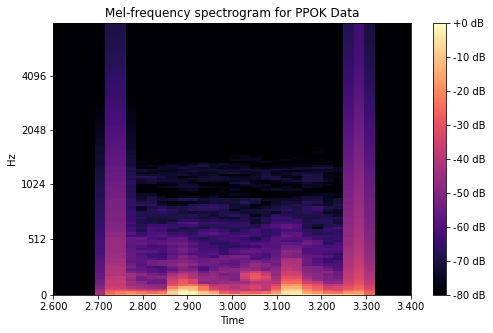

In [ ]:
mspec = df.iloc[42]["mspec"]

#Displaying  the MelSpectogram:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
S_dB = librosa.power_to_db(mspec, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram for PPOK Data')
plt.xlim(2.6,3.4)
plt.show()

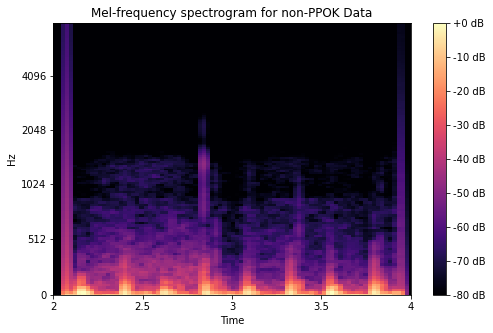

In [ ]:
mspec = df.iloc[24]["mspec"]

#Displaying  the MelSpectogram:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,5))
S_dB = librosa.power_to_db(mspec, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram for non-PPOK Data')
plt.xlim(2,4)
plt.show()

In [ ]:
'''
Matrix Similarity
'''
a = df.iloc[24]["mfcc"].flatten()
b = df.iloc[42]["mfcc"].flatten()

from scipy import spatial
result = 1 - spatial.distance.cosine(a, b)
result

0.9870253205299377

## From Raw File

In [ ]:
df["index"] = [i for i in range(len(df))]

In [ ]:
df.iloc[42]

patient_id                                                  104
rec_index                                                   1b1
chest_loc                                                    Al
acq_mode                                                     sc
rec_equip                                              Litt3200
start                                                       0.0
end                                                      1.8771
crackles                                                      0
weezels                                                       0
file_name                                104_1b1_Al_sc_Litt3200
diag                                                       COPD
mfcc          [[-613.4402, -613.4402, -613.4402, -613.4402, ...
cstft         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
mspec         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
len_mfcc                                                     20
len_cstft                               

In [ ]:
df.iloc[23]

patient_id                                                  102
rec_index                                                   1b1
chest_loc                                                    Ar
acq_mode                                                     sc
rec_equip                                              Meditron
start                                                     0.264
end                                                       1.736
crackles                                                      0
weezels                                                       0
file_name                                102_1b1_Ar_sc_Meditron
diag                                                    Healthy
mfcc          [[-613.4402, -613.4402, -613.4402, -613.4402, ...
cstft         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
mspec         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
len_mfcc                                                     20
len_cstft                               

In [ ]:
df["diag"].unique()

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis'],
      dtype=object)

In [ ]:
df[df["diag"] == "Healthy"]["index"]

0      23
1      24
2      25
3      26
4      27
     ... 
4    3980
5    3981
6    3982
7    3983
8    3984
Name: index, Length: 176, dtype: int64

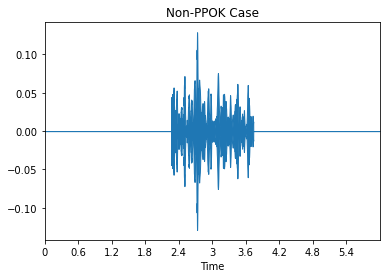

In [ ]:
librosa.display.waveplot(audio_arr[23],
                         sr = 22050,
                         max_points = 50000,
                         x_axis ='time', offset=0.0, max_sr=1000)
plt.title("Non-PPOK Case")
plt.show()

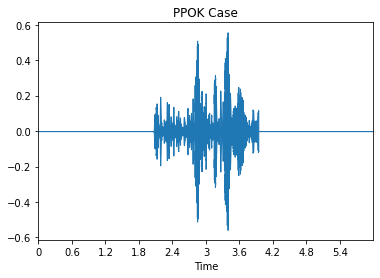

In [ ]:
librosa.display.waveplot(audio_arr[42],
                         sr = 22050,
                         max_points = 50000)
                         #x_axis ='time', offset=0.0, max_sr=1000)
plt.title("PPOK Case")
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(data1,sr=sample_rate1, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)

# MODELING

In [ ]:
df["binary_diag"] = df["diag"].apply(lambda row : "non-COPD" if row != "COPD" else row)

## LSTM using MFCC only

In [ ]:
#Feature
X = np.array(df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())
#X = tf.convert_to_tensor(np.array(final["data"].to_list()))
#X = [array for array in final["data"]]

#Target
y = np.array(df["binary_diag"].to_list())
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y)) #similar with get_dummies function in pandas
#y = labelencoder.fit_transform(y)

#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1])
#y_train = y_train.reshape(y_train.shape[0],1, 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
#y_test = y_test.reshape(y_test.shape[0],1, 1)

ValueError: ignored

In [ ]:
print(f"Training data shape : {X_train.shape}")
print(f"Training label shape : {y_train.shape}")
print(f"Validation data shape : {X_test.shape}")
print(f"Validation label shape : {y_test.shape}")

Training data shape : (154, 40, 1)
Training label shape : (154, 4)
Validation data shape : (77, 40, 1)
Validation label shape : (77, 4)


In [ ]:
import keras
from tensorflow.keras.layers import LSTM, Dense,Dropout

input_shape=(40,1)

model = keras.Sequential()
model.add(LSTM(256,input_shape=input_shape))
model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax')) #output 4

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [ ]:
import keras
from tensorflow.keras.layers import LSTM, Dense,Dropout

input_shape=(40,1)

model = keras.Sequential()
model.add(LSTM(256,input_shape=input_shape))
model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(4, activation='softmax')) #output 4

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)               

In [ ]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size = 72, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
3/3 [==============================] - 4s 505ms/step - loss: 1.6053 - accuracy: 0.0974 - val_loss: 1.5396 - val_accuracy: 0.1039
Epoch 2/100
3/3 [==============================] - 1s 197ms/step - loss: 1.5295 - accuracy: 0.0974 - val_loss: 1.4708 - val_accuracy: 0.1039
Epoch 3/100
3/3 [==============================] - 1s 197ms/step - loss: 1.4616 - accuracy: 0.0974 - val_loss: 1.4144 - val_accuracy: 0.1039
Epoch 4/100
3/3 [==============================] - 1s 190ms/step - loss: 1.4059 - accuracy: 0.0974 - val_loss: 1.3710 - val_accuracy: 0.1039
Epoch 5/100
3/3 [==============================] - 1s 186ms/step - loss: 1.3616 - accuracy: 0.1234 - val_loss: 1.3374 - val_accuracy: 0.5325
Epoch 6/100
3/3 [==============================] - 1s 185ms/step - loss: 1.3276 - accuracy: 0.4935 - val_loss: 1.3114 - val_accuracy: 0.5325
Epoch 7/100
3/3 [==============================] - 1s 183ms/step - loss: 1.3022 - accuracy: 0.5390 - val_loss: 1.2908 - val_accuracy: 0.5325
Epoch 8/100
3

## CNN Using MFCC ONLY

In [ ]:
df["binary_diag"] = df["diag"].apply(lambda row : "non-COPD" if row != "COPD" else row)

### With Overall Imbalanced Data

In [ ]:
'''
60-40 Train Test Data [UNDERSAMPLE]
'''
temp_df = pd.concat((df[df["binary_diag"] != "COPD"][["mfcc" , "binary_diag"]] , df[df["binary_diag"] == "COPD"][["mfcc" , "binary_diag"]].sample(len(df[df["binary_diag"] != "COPD"]), random_state = 42)))
temp_df

,mfcc,binary_diag
0,"[[-613.4402, -613.4402, -613.4402, -613.4402, ...",non-COPD
1,"[[-621.05994, -621.05994, -621.05994, -621.059...",non-COPD
2,"[[-619.62665, -619.62665, -619.62665, -619.626...",non-COPD
3,"[[-629.2678, -629.2678, -629.2678, -629.2678, ...",non-COPD
4,"[[-655.7785, -655.7785, -655.7785, -655.7785, ...",non-COPD
...,...,...
0,"[[-613.4402, -613.4402, -613.4402, -613.4402, ...",COPD
0,"[[-613.4402, -613.4402, -613.4402, -613.4402, ...",COPD
0,"[[-613.4402, -613.4402, -613.4402, -613.4402, ...",COPD
4,"[[-655.7785, -655.7785, -655.7785, -655.7785, ...",COPD


In [ ]:
#Feature
X = np.array(temp_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()} #inverse mapping
y = np.array(temp_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
'''
Test Proportion of Train and Test
'''
print("Train :")
print(pd.Series(y_train).map(inv_diag_dict).value_counts()  / len(y_train) * 100)
print("\nTest: ")
print(pd.Series(y_test).map(inv_diag_dict).value_counts()  / len(y_test) * 100)

Train :
non-COPD    50.157068
COPD        49.842932
dtype: float64

Test: 
COPD        50.318471
non-COPD    49.681529
dtype: float64


In [ ]:
'''
CNN MODEL
'''
from tensorflow import keras

mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.GlobalMaxPooling2D()(x)

hidden=keras.layers.Dropout(0.2)(x)
hidden=keras.layers.Dense(50,activation='relu')(x)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
mfcc_output=keras.layers.Dense(2,activation='softmax')(hidden)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
'''
Set Checkpoint for the best model
'''
from tensorflow.keras.callbacks import ModelCheckpoint
import time
filepath = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/MFCC_CNN_50-50.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_loss",verbose=1, save_best_only=True, mode="min")

callbacks = [checkpoint]

'''
Compile and Fitting Model
'''
mfcc_model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
start = time.time()
mfcc_model = mfcc_model.fit(X_train, y_train, epochs=50,
               validation_data = (X_test, y_test),
               callbacks = callbacks)
print(f"Runtime {time.time()-start} seconds")

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.8388 - accuracy: 0.5026
Epoch 1: val_loss improved from inf to 0.69612, saving model to /content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/MFCC_CNN_50-50.epoch01-loss0.70.hdf5
30/30 [==============================] - 7s 135ms/step - loss: 0.8388 - accuracy: 0.5026 - val_loss: 0.6961 - val_accuracy: 0.5032
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.4859
Epoch 2: val_loss improved from 0.69612 to 0.69336, saving model to /content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/MFCC_CNN_50-50.epoch02-loss0.69.hdf5
30/30 [==============================] - 3s 117ms/step - loss: 0.7166 - accuracy: 0.4859 - val_loss: 0.6934 - val_accuracy: 0.4968
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.4942
Epoch 3: val_loss did not improve from 0.69336
30/30 [==============================] - 3s 116ms/s

## Binary Class DataSet

### Imbalanced Data Set

#### Training

##### Splitting Dataset

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.33, random_state = 42)

'''
CSTFT
'''
#Feature
cstft_X = np.array(df["cstft"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
cstft_y = np.array(df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
cstft_X_train, cstft_X_test, cstft_y_train, cstft_y_test = train_test_split(cstft_X, cstft_y, test_size = 0.33, random_state = 42)

'''
Chroma
'''
#Feature
chroma_X = np.array(df["mspec"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
chroma_y = np.array(df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
chroma_X_train, chroma_X_test, chroma_y_train, chroma_y_test = train_test_split(chroma_X, chroma_y, test_size = 0.33, random_state = 42)


In [ ]:
'''
Test Proportion of Train and Test
'''
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()}
print("MFCC")
print("Train :")
print(pd.Series(mfcc_y_train).map(inv_diag_dict).value_counts()  / len(mfcc_y_train) * 100)
print("\nTest: ")
print(pd.Series(mfcc_y_test).map(inv_diag_dict).value_counts()  / len(mfcc_y_test) * 100)
print()
print("CSTFT")
print("Train :")
print(pd.Series(cstft_y_train).map(inv_diag_dict).value_counts()  / len(cstft_y_train) * 100)
print("\nTest: ")
print(pd.Series(cstft_y_test).map(inv_diag_dict).value_counts()  / len(cstft_y_test) * 100)
print()
print("CHROMA")
print("Train :")
print(pd.Series(chroma_y_train).map(inv_diag_dict).value_counts()  / len(chroma_y_train) * 100)
print("\nTest: ")
print(pd.Series(chroma_y_test).map(inv_diag_dict).value_counts()  / len(chroma_y_test) * 100)
print()

MFCC
Train :
COPD        83.142177
non-COPD    16.857823
dtype: float64

Test: 
COPD        83.618797
non-COPD    16.381203
dtype: float64

CSTFT
Train :
COPD        83.142177
non-COPD    16.857823
dtype: float64

Test: 
COPD        83.618797
non-COPD    16.381203
dtype: float64

CHROMA
Train :
COPD        83.142177
non-COPD    16.857823
dtype: float64

Test: 
COPD        83.618797
non-COPD    16.381203
dtype: float64



In [ ]:
print("MFCC")
print(f"Training data shape : {mfcc_X_train.shape}")
print(f"Training label shape : {mfcc_y_train.shape}")
print(f"Validation data shape : {mfcc_X_test.shape}")
print(f"Validation label shape : {mfcc_y_test.shape}")
print()
print("CSTFT")
print(f"Training data shape : {cstft_X_train.shape}")
print(f"Training label shape : {cstft_y_train.shape}")
print(f"Validation data shape : {cstft_X_test.shape}")
print(f"Validation label shape : {cstft_y_test.shape}")
print()
print("CHROMA")
print(f"Training data shape : {chroma_X_train.shape}")
print(f"Training label shape : {chroma_y_train.shape}")
print(f"Validation data shape : {chroma_X_test.shape}")
print(f"Validation label shape : {chroma_y_test.shape}")
print()

MFCC
Training data shape : (4621, 20, 259)
Training label shape : (4621,)
Validation data shape : (2277, 20, 259)
Validation label shape : (2277,)

CSTFT
Training data shape : (4621, 12, 259)
Training label shape : (4621,)
Validation data shape : (2277, 12, 259)
Validation label shape : (2277,)

CHROMA
Training data shape : (4621, 128, 259)
Training label shape : (4621,)
Validation data shape : (2277, 128, 259)
Validation label shape : (2277,)



##### Model

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(4,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
np.logical_and( (mfcc_y_train==cstft_y_train).all(), (cstft_y_train==chroma_y_train).all() )

True

In [ ]:
np.logical_and( (mfcc_y_test==cstft_y_test).all(), (cstft_y_test==chroma_y_test).all() )

True

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

history=net.fit(
    {"mfcc":mfcc_X_train,"croma":cstft_X_train,"mspec":chroma_X_train},
    mfcc_y_train,
    validation_data=({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test},mfcc_y_test),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

#### Model Evaluation

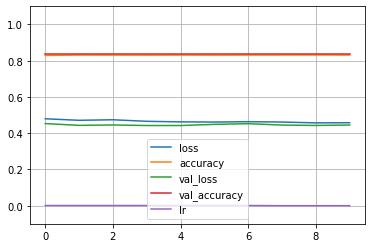

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
net.save("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/3type_binary_imbalanced.hdf5")

In [ ]:
'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_imbalanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test})
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = mfcc_y_test

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

72/72 [==============================] - 8s 105ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       373
        COPD       0.84      1.00      0.91      1904

    accuracy                           0.84      2277
   macro avg       0.42      0.50      0.46      2277
weighted avg       0.70      0.84      0.76      2277



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


41/41 [==============================] - 4s 84ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       373
        COPD       0.71      1.00      0.83       932

    accuracy                           0.71      1305
   macro avg       0.36      0.50      0.42      1305
weighted avg       0.51      0.71      0.60      1305



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


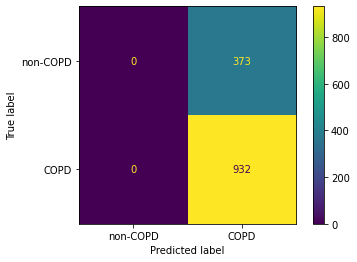

In [ ]:
'''
70 (COPD) - 30 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) * 2.5),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_imbalanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

35/35 [==============================] - 4s 110ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       373
        COPD       0.67      1.00      0.80       746

    accuracy                           0.67      1119
   macro avg       0.33      0.50      0.40      1119
weighted avg       0.44      0.67      0.53      1119



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


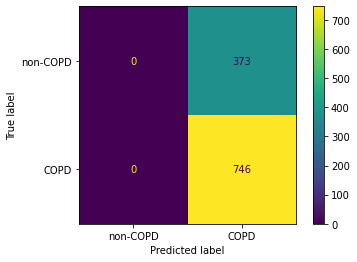

In [ ]:
'''
60 (COPD) - 40 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) * 2),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_imbalanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

24/24 [==============================] - 2s 65ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       373
        COPD       0.50      1.00      0.67       373

    accuracy                           0.50       746
   macro avg       0.25      0.50      0.33       746
weighted avg       0.25      0.50      0.33       746



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


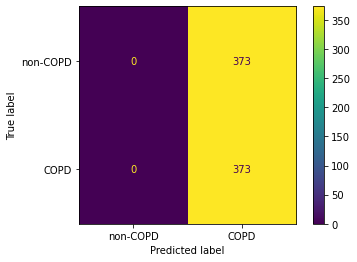

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_imbalanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

precision dari COPD : seberapa bagus model menebak dia COPD (TP / (TP+FP)) \
recall :  \
f1_score : sensitivity , TP /(TP+FN)

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"].sample(round(len(eq_df_1) * 2),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts() / len(eq_df) * 100

COPD        66.666667
non-COPD    33.333333
Name: binary_diag, dtype: float64

### Balanced Data Set

#### Training

##### Splitting Data

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"].sample(len(eq_df_1),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts()

non-COPD    713
COPD        713
Name: binary_diag, dtype: int64

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(eq_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.2, random_state = 42)

'''
CSTFT
'''
#Feature
cstft_X = np.array(eq_df["cstft"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
cstft_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
cstft_X_train, cstft_X_test, cstft_y_train, cstft_y_test = train_test_split(cstft_X, cstft_y, test_size = 0.2, random_state = 42)

'''
Mel Spectogram
'''
#Feature
chroma_X = np.array(eq_df["mspec"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
chroma_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
chroma_X_train, chroma_X_test, chroma_y_train, chroma_y_test = train_test_split(chroma_X, chroma_y, test_size = 0.2, random_state = 42)


In [ ]:
'''
Test Proportion of Train and Test
'''
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()}
print("MFCC")
print("Train :")
print(pd.Series(mfcc_y_train).map(inv_diag_dict).value_counts()  / len(mfcc_y_train) * 100)
print("\nTest: ")
print(pd.Series(mfcc_y_test).map(inv_diag_dict).value_counts()  / len(mfcc_y_test) * 100)
print()
print("CSTFT")
print("Train :")
print(pd.Series(cstft_y_train).map(inv_diag_dict).value_counts()  / len(cstft_y_train) * 100)
print("\nTest: ")
print(pd.Series(cstft_y_test).map(inv_diag_dict).value_counts()  / len(cstft_y_test) * 100)
print()
print("CHROMA")
print("Train :")
print(pd.Series(chroma_y_train).map(inv_diag_dict).value_counts()  / len(chroma_y_train) * 100)
print("\nTest: ")
print(pd.Series(chroma_y_test).map(inv_diag_dict).value_counts()  / len(chroma_y_test) * 100)
print()

MFCC
Train :
non-COPD    50.614035
COPD        49.385965
dtype: float64

Test: 
COPD        52.447552
non-COPD    47.552448
dtype: float64

CSTFT
Train :
non-COPD    50.614035
COPD        49.385965
dtype: float64

Test: 
COPD        52.447552
non-COPD    47.552448
dtype: float64

CHROMA
Train :
non-COPD    50.614035
COPD        49.385965
dtype: float64

Test: 
COPD        52.447552
non-COPD    47.552448
dtype: float64



In [ ]:
print("MFCC")
print(f"Training data shape : {mfcc_X_train.shape}")
print(f"Training label shape : {mfcc_y_train.shape}")
print(f"Validation data shape : {mfcc_X_test.shape}")
print(f"Validation label shape : {mfcc_y_test.shape}")
print()
print("CSTFT")
print(f"Training data shape : {cstft_X_train.shape}")
print(f"Training label shape : {cstft_y_train.shape}")
print(f"Validation data shape : {cstft_X_test.shape}")
print(f"Validation label shape : {cstft_y_test.shape}")
print()
print("CHROMA")
print(f"Training data shape : {chroma_X_train.shape}")
print(f"Training label shape : {chroma_y_train.shape}")
print(f"Validation data shape : {chroma_X_test.shape}")
print(f"Validation label shape : {chroma_y_test.shape}")
print()

MFCC
Training data shape : (1140, 20, 259)
Training label shape : (1140,)
Validation data shape : (286, 20, 259)
Validation label shape : (286,)

CSTFT
Training data shape : (1140, 12, 259)
Training label shape : (1140,)
Validation data shape : (286, 12, 259)
Validation label shape : (286,)

CHROMA
Training data shape : (1140, 128, 259)
Training label shape : (1140,)
Validation data shape : (286, 128, 259)
Validation label shape : (286,)



##### Model

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(2,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

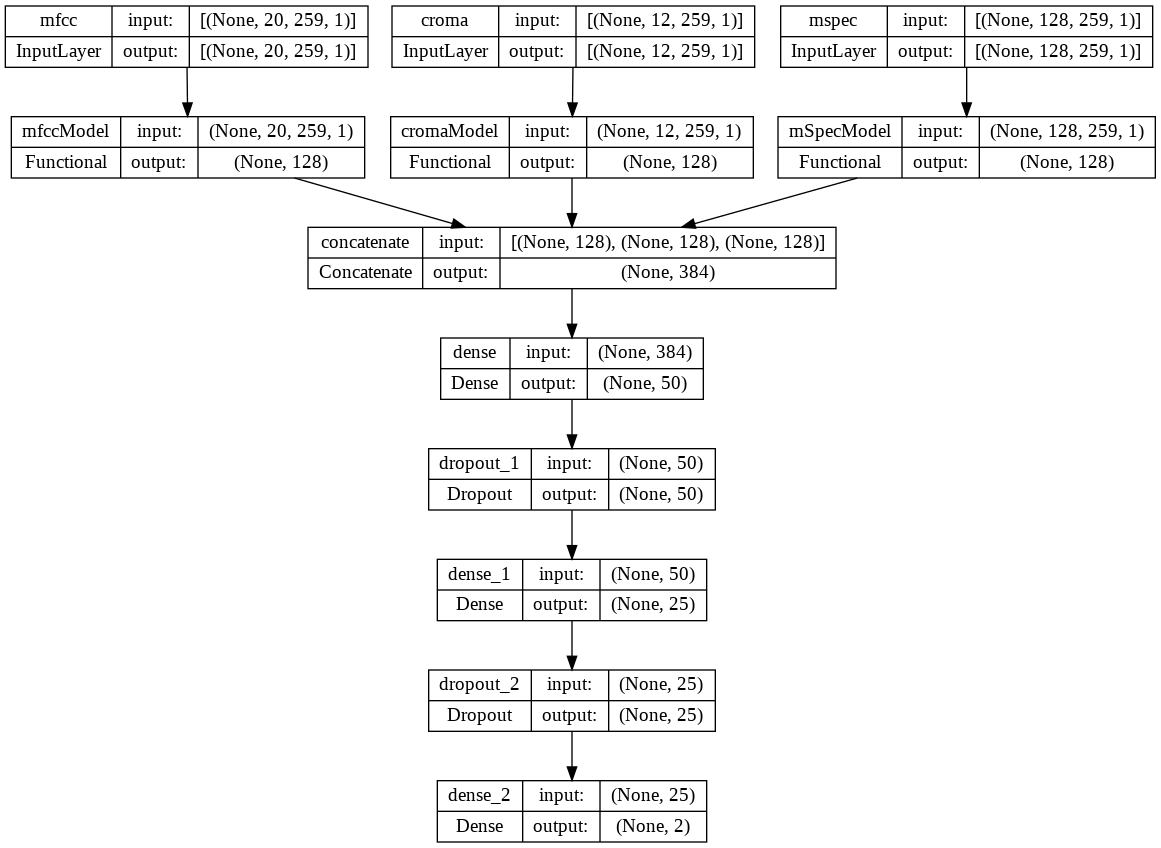

In [ ]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
np.logical_and( (mfcc_y_train==cstft_y_train).all(), (cstft_y_train==chroma_y_train).all() )

True

In [ ]:
np.logical_and( (mfcc_y_test==cstft_y_test).all(), (cstft_y_test==chroma_y_test).all() )

True

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]
#harusnya chroma --> mSpec
history=net.fit(
    {"mfcc":mfcc_X_train,"croma":cstft_X_train,"mspec":chroma_X_train},
    mfcc_y_train,
    validation_data=({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test},mfcc_y_test),
    epochs=50,verbose=0,
    callbacks=my_callbacks
)

In [ ]:
net.save("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/3type_binary_balanced_7nov.hdf5")

#### Model Evaluation

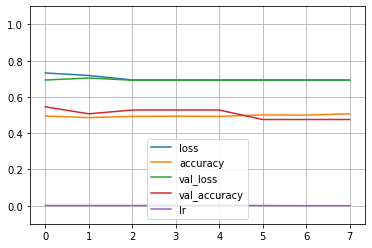

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
'''
Load Model and Predict the Test Data on Training Table
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test})
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = mfcc_y_test

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

9/9 [==============================] - 2s 120ms/step
              precision    recall  f1-score   support

    non-COPD       0.48      1.00      0.64       136
        COPD       0.00      0.00      0.00       150

    accuracy                           0.48       286
   macro avg       0.24      0.50      0.32       286
weighted avg       0.23      0.48      0.31       286



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
'''
70 (COPD) - 30 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) * 2.5),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

ValueError: ignored

9/9 [==============================] - 2s 165ms/step
              precision    recall  f1-score   support

    non-COPD       0.50      1.00      0.67       136
        COPD       0.00      0.00      0.00       136

    accuracy                           0.50       272
   macro avg       0.25      0.50      0.33       272
weighted avg       0.25      0.50      0.33       272



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


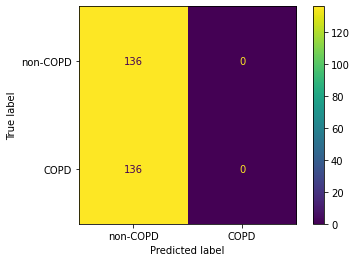

In [ ]:
'''
60 (COPD) - 40 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) ),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced_7nov.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

### in between Balanced Data Set 70 - 30 training process

#### Training

##### Splitting Data

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"].sample(round(len(eq_df_1)*2.5),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts() / len(eq_df)

COPD        0.714286
non-COPD    0.285714
Name: binary_diag, dtype: float64

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(eq_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.33, random_state = 42)

'''
CSTFT
'''
#Feature
cstft_X = np.array(eq_df["cstft"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
cstft_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
cstft_X_train, cstft_X_test, cstft_y_train, cstft_y_test = train_test_split(cstft_X, cstft_y, test_size = 0.33, random_state = 42)

'''
Chroma
'''
#Feature
chroma_X = np.array(eq_df["mspec"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
chroma_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
chroma_X_train, chroma_X_test, chroma_y_train, chroma_y_test = train_test_split(chroma_X, chroma_y, test_size = 0.33, random_state = 42)


In [ ]:
'''
Test Proportion of Train and Test
'''
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()}
print("MFCC")
print("Train :")
print(pd.Series(mfcc_y_train).map(inv_diag_dict).value_counts()  / len(mfcc_y_train) * 100)
print("\nTest: ")
print(pd.Series(mfcc_y_test).map(inv_diag_dict).value_counts()  / len(mfcc_y_test) * 100)
print()
print("CSTFT")
print("Train :")
print(pd.Series(cstft_y_train).map(inv_diag_dict).value_counts()  / len(cstft_y_train) * 100)
print("\nTest: ")
print(pd.Series(cstft_y_test).map(inv_diag_dict).value_counts()  / len(cstft_y_test) * 100)
print()
print("CHROMA")
print("Train :")
print(pd.Series(chroma_y_train).map(inv_diag_dict).value_counts()  / len(chroma_y_train) * 100)
print("\nTest: ")
print(pd.Series(chroma_y_test).map(inv_diag_dict).value_counts()  / len(chroma_y_test) * 100)
print()

MFCC
Train :
COPD        72.343576
non-COPD    27.656424
dtype: float64

Test: 
COPD        69.571751
non-COPD    30.428249
dtype: float64

CSTFT
Train :
COPD        72.343576
non-COPD    27.656424
dtype: float64

Test: 
COPD        69.571751
non-COPD    30.428249
dtype: float64

CHROMA
Train :
COPD        72.343576
non-COPD    27.656424
dtype: float64

Test: 
COPD        69.571751
non-COPD    30.428249
dtype: float64



In [ ]:
print("MFCC")
print(f"Training data shape : {mfcc_X_train.shape}")
print(f"Training label shape : {mfcc_y_train.shape}")
print(f"Validation data shape : {mfcc_X_test.shape}")
print(f"Validation label shape : {mfcc_y_test.shape}")
print()
print("CSTFT")
print(f"Training data shape : {cstft_X_train.shape}")
print(f"Training label shape : {cstft_y_train.shape}")
print(f"Validation data shape : {cstft_X_test.shape}")
print(f"Validation label shape : {cstft_y_test.shape}")
print()
print("CHROMA")
print(f"Training data shape : {chroma_X_train.shape}")
print(f"Training label shape : {chroma_y_train.shape}")
print(f"Validation data shape : {chroma_X_test.shape}")
print(f"Validation label shape : {chroma_y_test.shape}")
print()

MFCC
Training data shape : (2701, 20, 259)
Training label shape : (2701,)
Validation data shape : (1331, 20, 259)
Validation label shape : (1331,)

CSTFT
Training data shape : (2701, 12, 259)
Training label shape : (2701,)
Validation data shape : (1331, 12, 259)
Validation label shape : (1331,)

CHROMA
Training data shape : (2701, 128, 259)
Training label shape : (2701,)
Validation data shape : (1331, 128, 259)
Validation label shape : (1331,)



##### Model

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(2,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
np.logical_and( (mfcc_y_train==cstft_y_train).all(), (cstft_y_train==chroma_y_train).all() )

True

In [ ]:
np.logical_and( (mfcc_y_test==cstft_y_test).all(), (cstft_y_test==chroma_y_test).all() )

True

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

history=net.fit(
    {"mfcc":mfcc_X_train,"croma":cstft_X_train,"mspec":chroma_X_train},
    mfcc_y_train,
    validation_data=({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test},mfcc_y_test),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

In [ ]:
net.save("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/3type_binary_70-30.hdf5")

#### Model Evaluation

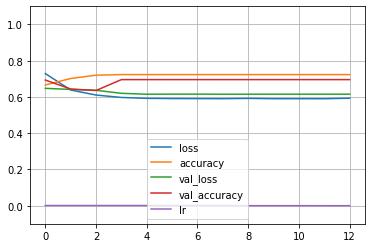

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

42/42 [==============================] - 11s 241ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       405
        COPD       0.70      1.00      0.82       926

    accuracy                           0.70      1331
   macro avg       0.35      0.50      0.41      1331
weighted avg       0.48      0.70      0.57      1331



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


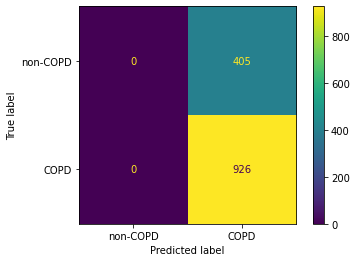

In [ ]:
'''
70 (COPD) - 30 (non-COPD)
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_70-30.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test})
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = mfcc_y_test

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))


'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

32/32 [==============================] - 4s 108ms/step
              precision    recall  f1-score   support

    non-COPD       0.52      0.25      0.34       405
        COPD       0.63      0.84      0.72       608

    accuracy                           0.61      1013
   macro avg       0.57      0.55      0.53      1013
weighted avg       0.58      0.61      0.57      1013



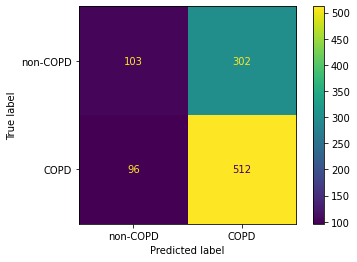

In [ ]:
'''
60 (COPD) - 40 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) * 1.5),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

26/26 [==============================] - 5s 166ms/step
              precision    recall  f1-score   support

    non-COPD       0.64      0.25      0.36       405
        COPD       0.53      0.86      0.66       405

    accuracy                           0.56       810
   macro avg       0.59      0.56      0.51       810
weighted avg       0.59      0.56      0.51       810



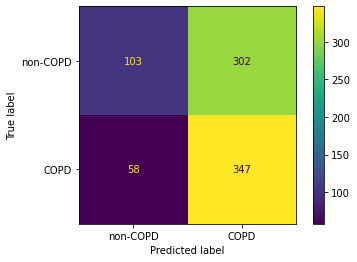

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

### in between Balanced Data Set 60 - 40 training process

#### Training

##### Splitting Data

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"].sample(round(len(eq_df_1)*1.5),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts() / len(eq_df)

COPD        0.6
non-COPD    0.4
Name: binary_diag, dtype: float64

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(eq_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.33, random_state = 42)

'''
CSTFT
'''
#Feature
cstft_X = np.array(eq_df["cstft"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
cstft_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
cstft_X_train, cstft_X_test, cstft_y_train, cstft_y_test = train_test_split(cstft_X, cstft_y, test_size = 0.33, random_state = 42)

'''
Chroma
'''
#Feature
chroma_X = np.array(eq_df["mspec"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
chroma_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
chroma_X_train, chroma_X_test, chroma_y_train, chroma_y_test = train_test_split(chroma_X, chroma_y, test_size = 0.33, random_state = 42)


In [ ]:
'''
Test Proportion of Train and Test
'''
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()}
print("MFCC")
print("Train :")
print(pd.Series(mfcc_y_train).map(inv_diag_dict).value_counts()  / len(mfcc_y_train) * 100)
print("\nTest: ")
print(pd.Series(mfcc_y_test).map(inv_diag_dict).value_counts()  / len(mfcc_y_test) * 100)
print()
print("CSTFT")
print("Train :")
print(pd.Series(cstft_y_train).map(inv_diag_dict).value_counts()  / len(cstft_y_train) * 100)
print("\nTest: ")
print(pd.Series(cstft_y_test).map(inv_diag_dict).value_counts()  / len(cstft_y_test) * 100)
print()
print("CHROMA")
print("Train :")
print(pd.Series(chroma_y_train).map(inv_diag_dict).value_counts()  / len(chroma_y_train) * 100)
print("\nTest: ")
print(pd.Series(chroma_y_test).map(inv_diag_dict).value_counts()  / len(chroma_y_test) * 100)
print()

MFCC
Train :
COPD        60.653188
non-COPD    39.346812
dtype: float64

Test: 
COPD        58.675079
non-COPD    41.324921
dtype: float64

CSTFT
Train :
COPD        60.653188
non-COPD    39.346812
dtype: float64

Test: 
COPD        58.675079
non-COPD    41.324921
dtype: float64

CHROMA
Train :
COPD        60.653188
non-COPD    39.346812
dtype: float64

Test: 
COPD        58.675079
non-COPD    41.324921
dtype: float64



In [ ]:
print("MFCC")
print(f"Training data shape : {mfcc_X_train.shape}")
print(f"Training label shape : {mfcc_y_train.shape}")
print(f"Validation data shape : {mfcc_X_test.shape}")
print(f"Validation label shape : {mfcc_y_test.shape}")
print()
print("CSTFT")
print(f"Training data shape : {cstft_X_train.shape}")
print(f"Training label shape : {cstft_y_train.shape}")
print(f"Validation data shape : {cstft_X_test.shape}")
print(f"Validation label shape : {cstft_y_test.shape}")
print()
print("CHROMA")
print(f"Training data shape : {chroma_X_train.shape}")
print(f"Training label shape : {chroma_y_train.shape}")
print(f"Validation data shape : {chroma_X_test.shape}")
print(f"Validation label shape : {chroma_y_test.shape}")
print()

MFCC
Training data shape : (1929, 20, 259)
Training label shape : (1929,)
Validation data shape : (951, 20, 259)
Validation label shape : (951,)

CSTFT
Training data shape : (1929, 12, 259)
Training label shape : (1929,)
Validation data shape : (951, 12, 259)
Validation label shape : (951,)

CHROMA
Training data shape : (1929, 128, 259)
Training label shape : (1929,)
Validation data shape : (951, 128, 259)
Validation label shape : (951,)



##### Model

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 87, 32)        832       
                                                                 
 batch_normalization_11 (Bat  (None, 20, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_15 (Bat  (None, 12, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_18 (Bat  (None, 64, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(2,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
np.logical_and( (mfcc_y_train==cstft_y_train).all(), (cstft_y_train==chroma_y_train).all() )

True

In [ ]:
np.logical_and( (mfcc_y_test==cstft_y_test).all(), (cstft_y_test==chroma_y_test).all() )

True

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

history=net.fit(
    {"mfcc":mfcc_X_train,"croma":cstft_X_train,"mspec":chroma_X_train},
    mfcc_y_train,
    validation_data=({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test},mfcc_y_test),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

In [ ]:
net.save("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/3type_binary_60-40.hdf5")

#### Model Evaluation

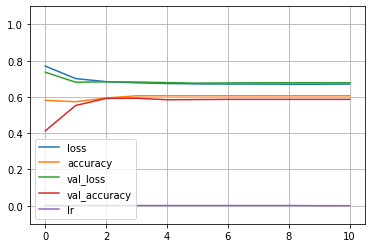

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

26/26 [==============================] - 5s 178ms/step
              precision    recall  f1-score   support

    non-COPD       0.45      0.29      0.35       248
        COPD       0.73      0.84      0.78       558

    accuracy                           0.67       806
   macro avg       0.59      0.57      0.57       806
weighted avg       0.64      0.67      0.65       806



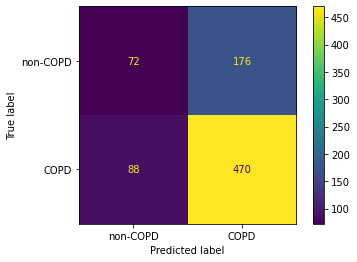

In [ ]:
'''
70 (COPD) - 30 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0]  #non-COPD
eq_y_0 = eq_y_0.sample(round(len(eq_y_0) * 0.63))
eq_y_1 = eq_y[eq_y == 1] #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

30/30 [==============================] - 5s 164ms/step
              precision    recall  f1-score   support

    non-COPD       0.54      0.27      0.36       393
        COPD       0.62      0.84      0.71       558

    accuracy                           0.60       951
   macro avg       0.58      0.55      0.54       951
weighted avg       0.59      0.60      0.57       951



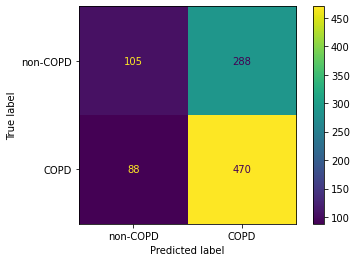

In [ ]:
'''
60 (COPD) - 40 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1]#.sample(round(len(eq_y_0) * 2),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

25/25 [==============================] - 4s 108ms/step
              precision    recall  f1-score   support

    non-COPD       0.66      0.27      0.38       393
        COPD       0.54      0.86      0.66       393

    accuracy                           0.56       786
   macro avg       0.60      0.56      0.52       786
weighted avg       0.60      0.56      0.52       786



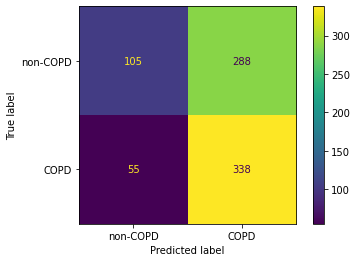

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

# Other Model Test

In [ ]:
'''
Load Model and Predict the Test Data on Training Table
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "binary_classification_all.epoch45-loss0.69.hdf5"

model = keras.models.load_model(directory+best_model_file)

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"]#.sample(len(eq_df_1),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts()

COPD        3486
non-COPD     713
Name: binary_diag, dtype: int64

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(eq_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.2, random_state = 42)

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)*1.5),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc = mfcc_X_test[eq_y.index]

In [ ]:
eq_y.value_counts() / len(eq_y)

1    0.600484
0    0.399516
dtype: float64

In [ ]:
y_pred_weights = model.predict(mfcc_X_test)
y_pred_label = np.argmax(y_pred_weights, axis=-1)
y_true = mfcc_y_test

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

27/27 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

    non-COPD       0.21      0.79      0.33       165
        COPD       0.84      0.26      0.40       675

    accuracy                           0.37       840
   macro avg       0.52      0.53      0.36       840
weighted avg       0.71      0.37      0.39       840

